# Comparison of First and Second-Order FEM (P1/P2 elements)
The discretization error due to the finite-element scheme is a function of the number of elements. If we use more elements we wish for the error to get smaller. To verify the relation between number of nodes and error, we run a benchmark using a simple problem which has an analytical solution.
The discretization error between the analytical solution $u(x)$ and FE solution $u^h(x)$ is measured using the infinity norm:
$$ E = || u(x) - u^h(x) ||_{\infty} $$
By using higher-order elements, we expect the error to decrease faster than lower-order elements as more nodes are added. The expected slope is 
$−(m+1)$, where $m$ is the order of the element.

In [1]:
using LinearAlgebra, Statistics
using Interpolations

using Plots
using LaTeXStrings

## Analytical Solution
We will compare the first- and second-order elements using a simple problem with an analytical reference solution:
$$ -u^{\prime\prime}(x) = \sin(\pi x) \qquad x \in \Omega = (0, 1) $$
with $u(x=0) = 0$ and $u(x=1) = 1$. The analytical solution is derived using pen and paper:
$$ u(x) = \frac{1}{\pi^2} \sin(\pi x) + x $$

In [2]:
fsource(x) = sin(pi * x);
uex(x) = 1/(pi*pi) * sin(pi * x) + x;

## Auxilliary Functions
First, we define two functions to execute first- and second-order FEM with an arbitrary number of mesh nodes $N$.

In [3]:
# First-order FEM
function fem1(N)
    Np1 = N + 1; x  = collect(0:1/N:1)
    points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
    edges = collect( [i, i+1] for i in 1:length(x)-1);
    
    # Initialize global matrix and right-hand side vector
    A = zeros(Np1, Np1); 
    f = zeros(Np1); 

    # Perform loop over elements and construct A and f
    for i=1:length(edges) 
        xl, xr = points[i,:][1] 
        floc = (xr-xl) / 2 * [fsource(xl); fsource(xr)];
        Aloc = (1/(xr-xl))*[1 -1; -1 1];

        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    # Handle boundary conditions
    A[1,:]   = zeros(Np1);  A[1,1] = 1;      f[1]   = 0;   # Homogeneous Dirichlet condition in x = 0
    A[end,:] = zeros(Np1);  A[end,end] = 1;  f[end] = 1;   # Non-homogeneous Dirichlet condition (u = 1) in x = 1

    # Solve the linear system
    u  = A \ f;
    
    return x, u;
end

fem1 (generic function with 1 method)

In [4]:
# Second-order FEM
function fem2(N, xi)
    # Modify the 1D mesh with additional nodes on the midpoints
    x  = collect(0:1/N:1)
    Na = 2 * length(x) - 1;
    points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
    edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

    X = collect([points[i][1], points[i][2]] for i in 1:length(points))
    X = reduce(vcat, X);
    X = vcat(X, x[end]);

    # Initialize global matrix and right-hand side vector
    A = zeros(Na, Na); 
    f = zeros(Na); 

    # Perform loop over elements and construct A and f
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1] 
        floc = (xr-xl) / 6 * [fsource(xl); 4 * fsource(xm); fsource(xr)];
        Aloc = 1/(3*(xr-xl)) * [7 -8 1; -8 16 -8; 1 -8 7];

        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    # Handle boundary conditions
    A[1,:]   = zeros(Na);  A[1,1] = 1;      f[1]   = 0;   # Homogeneous Dirichlet condition in x = 0
    A[end,:] = zeros(Na);  A[end,end] = 1;  f[end] = 1;   # Non-homogeneous Dirichlet condition (u = 1) in x = 1

    # Solve the linear system
    u  = A \ f;
    
    # Interpolate using basis functions
    U    = zeros(length(xi));
    xmin = map(p -> p[1], points) # Left node of each element
    xmax = map(p -> p[3], points) # Right node of each element
    el   = (xi .>= xmin') .& (xi .< xmax'); # Interpolation nodes part of which element?

    for (i, xi_) in enumerate(xi)
        elnum = findfirst(el[i,:]);
        if(typeof(elnum) == Nothing)
            continue;
        end
        
        p  = points[elnum];
        e  = edges[elnum];
        x_ = (xi_ - p[1]) / (p[3] - p[1]) # Transform to reference element

        # Interpolate using reference shape functions
        U[i] = u[e[1]] * (0.5 - x_) * (2 - 2 * x_) +
                u[e[2]] * 4 * x_ * (1 - x_) +
                u[e[3]] * 2 * x_ * (x_ - 0.5);
    end
    U[end] = u[end]; # Last boundary point is missed in the calculation above
    
    return X, u, U;
end

fem2 (generic function with 1 method)

## Benchmark
Next, we run the benchmark problem for several values of $N = 2^n$, $n = 1,\dots,8$ and calculate the discretization error by comparing it to the analytical solution on an interpolated grid. The slope of the error for is plotted on a log-log scale for the implementations of first- and second-order basis functions.

In [5]:
N_ = [2,4,8,16,32,64,128,256];

err1 = zeros(length(N_));
err2 = zeros(length(N_));

xi  = collect(0:0.001:1);
Uex = uex.(xi);

In [6]:
for i = 1:length(N_)
    N = N_[i];
    
    # First-order FEM with linear interpolation
    x1, u1 = fem1(N);
    U1   = LinearInterpolation(x1, u1);
    
    # Second-order FEM
    x2, u2, U2 = fem2(N, xi);
    
    # Infinity norm of the error between FEM and analytical solution
    err1[i] = maximum(abs.(Uex - U1.(xi)));
    err2[i] = maximum(abs.(Uex - U2));
end

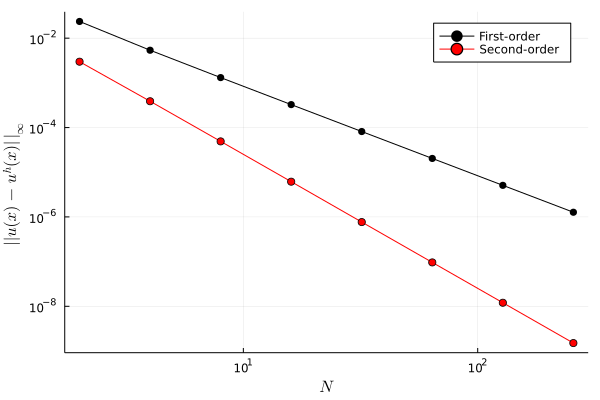

In [7]:
plot(N_, err1, xlabel = L"N", ylabel = L"||u(x) - u^h(x)||_{\infty}", xaxis = :log, yaxis = :log, label = "First-order", color = :black, shape = :circle)
plot!(N_, err2, label = "Second-order", color = :red, shape = :circle)

In [8]:
slope1 = Statistics.mean(diff(log10.(err1)) ./ diff(log10.(N_)))
slope2 = Statistics.mean(diff(log10.(err2)) ./ diff(log10.(N_)))

print("First order slope: ", slope1, '\n')
print("Second order slope: ", slope2, '\n')

First order slope: -2.0263846300352086
Second order slope: -2.9885177437972703
